NMIST digit classifier to test GPU

https://medium.com/@nutanbhogendrasharma/pytorch-convolutional-neural-network-with-mnist-dataset-4e8a4265e118

In [20]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [24]:

train_data = datasets.MNIST(
    root = '../data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = '../data', 
    train = False, 
    transform = ToTensor()
)

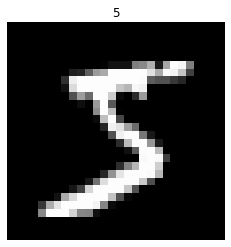

In [25]:
plt.imshow(train_data.data[0], cmap='gray')
plt.title('%i' % train_data.targets[0])
plt.axis("off")
None

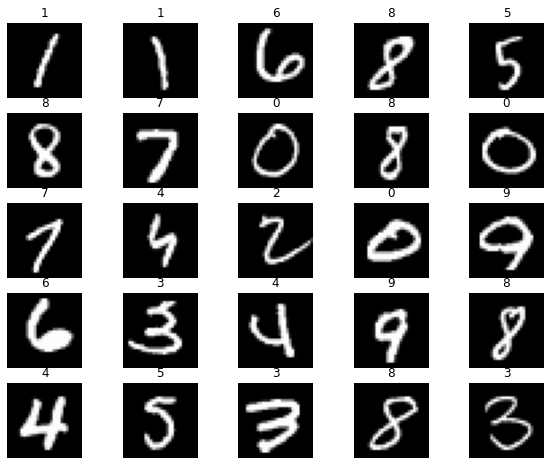

In [26]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")

In [27]:
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
}

In [28]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    # return x for visualization

In [29]:
num_epochs = 10
cnn = CNN()
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr = 0.01)

In [30]:
def train(num_epochs, cnn, loaders):
    cnn.train()
        
    # Train the model
    total_step = len(loaders['train'])
        
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            output = cnn(b_x)[0]               
            loss = loss_func(output, b_y)
            
            # clear gradients for this training step   
            optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
            loss.backward()    
            # apply gradients             
            optimizer.step()                
            
            if (i+1) % 100 == 0:
                print("Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}".format(
                    epoch + 1, num_epochs, i + 1, total_step, loss.item()
                ))

train(num_epochs, cnn, loaders)

/home/fireofearth/.local/miniconda3/envs/ml8/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch [1/10], Step [100/600], Loss: 0.0918
Epoch [1/10], Step [200/600], Loss: 0.1090
Epoch [1/10], Step [300/600], Loss: 0.0256
Epoch [1/10], Step [400/600], Loss: 0.1452
Epoch [1/10], Step [500/600], Loss: 0.0330
Epoch [1/10], Step [600/600], Loss: 0.0597
Epoch [2/10], Step [100/600], Loss: 0.0725
Epoch [2/10], Step [200/600], Loss: 0.0850
Epoch [2/10], Step [300/600], Loss: 0.0332
Epoch [2/10], Step [400/600], Loss: 0.0625
Epoch [2/10], Step [500/600], Loss: 0.0930
Epoch [2/10], Step [600/600], Loss: 0.1934
Epoch [3/10], Step [100/600], Loss: 0.1743
Epoch [3/10], Step [200/600], Loss: 0.0321
Epoch [3/10], Step [300/600], Loss: 0.0933
Epoch [3/10], Step [400/600], Loss: 0.0013
Epoch [3/10], Step [500/600], Loss: 0.0056
Epoch [3/10], Step [600/600], Loss: 0.0196
Epoch [4/10], Step [100/600], Loss: 0.0755
Epoch [4/10], Step [200/600], Loss: 0.0019
Epoch [4/10], Step [300/600], Loss: 0.0336
Epoch [4/10], Step [400/600], Loss: 0.0494
Epoch [4/10], Step [500/600], Loss: 0.0970
Epoch [4/10

In [31]:
def test():
    # Test the model
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['test']:
            test_output, last_layer = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
    print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)

test()

Test Accuracy of the model on the 10000 test images: 0.98
